# NOTE:
* Please do not edit the contents of the shared folder directly.
 * Rather, please copy the parent folder ["plant_health_classification"](https://drive.google.com/drive/folders/1fWuOuxmDy-eBWzaPUw78yJWgB-3obtXy?usp=share_link) to your own drive. 
* For instructions and expected outputs, see "TODOs" and "Deliverables summarized" respectively.

# TODOs
*** Please read all instructions through first to gauge the required effort and reach out if you have any questions whatsoever. ***
1. Reserve 15% of the training data for testing. Reserve these images in the directory "test_images". Reserve a percentage of the training images for evaluation as well.
2. Train an image classifier with an architecture and framework of your choosing. Please comment on your choices.
3. Evaluate the model using a loss(es) and metrics that would allow you to make informed model improvements. Save your model to your submission folder.

4. After evaluating, comment on any outstanding metrics (good or bad).

*** SKIP STEPS 5-6 IF YOU DO NOT HAVE TIME ***
5. Copy your training loop, making adjustments in consideration of any or all discoveries from steps 3-4. Please comment on these adjustments and why you're making them -- what problems are you trying to solve and how?
6. Evaluate your model for a second time. Please comment on the impact of the changes to the training loop, if any (it's fine if there's not). Save your model to your submission folder

7. Test your model against the test data. Reuse at least the same evaluation metrics from your training/evaluation steps. Produce and save a CSV with your submission results as shown above in the "sample_submission_df".

# Deliverables summarized
*** Please include the following in the copied GDrive folder. *** 
1. A Jupyter notebook (highly prefered) or similarly structured document showing your steps and outputs from the above TODOs. This notebook doesn't need to be anything fancy, but clarity and comments are appreciated. Please feel free to show as much of your workflow/exploration as you'd like. This is our chance to get to know you through your work.

2. Your model file from step #3.

3. Sample submission CSV from step #7.

*** IF YOU COMPLETED STEPS 5-6 ***
4. Your model file from step #6.



# Starter code:

In [2]:
# Ex:
# !ls YOUR_PATH_TO_SHARED_FOLDER/plant_health_classification/

In [3]:
import sys
sys.executable

'C:\\Users\\ravis\\Desktop\\workspace\\deep_sentinel\\venv_39\\Scripts\\python.exe'

In [4]:
# imports
import os
import sys

import sklearn
import logging
from argparse import ArgumentParser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import yaml


import time
import copy
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from PIL import Image


### Env variables and configurations

In [5]:
#env
torch.manual_seed(7)
torch.cuda.is_available()

# training config
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
image_size=config['hyperparams']['image_size']
batch_size=config['hyperparams']['batch_size']
num_workers=config['hyperparams']['num_workers']
epochs=config['hyperparams']['epochs']

log_interval=config['hyperparams']['log_interval']
lr=config['hyperparams']['lr']
gamma=config['hyperparams']['gamma']

In [6]:
cuda_available=torch.cuda.is_available()
device="cuda:0" if cuda_available else "cpu"
print("device: ",device)
device = torch.device(device)


device:  cpu


### FileSystem handling

C:/Users/ravis/Desktop/workspace/deep_sentinel\train_images\800113bb65efe69e.jpg


,image,labels,image_local_path
0,800113bb65efe69e.jpg,healthy,C:/Users/ravis/Desktop/workspace/deep_sentinel...
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,C:/Users/ravis/Desktop/workspace/deep_sentinel...
2,80070f7fb5e2ccaa.jpg,scab,C:/Users/ravis/Desktop/workspace/deep_sentinel...
3,80077517781fb94f.jpg,scab,C:/Users/ravis/Desktop/workspace/deep_sentinel...
4,800cbf0ff87721f8.jpg,complex,C:/Users/ravis/Desktop/workspace/deep_sentinel...


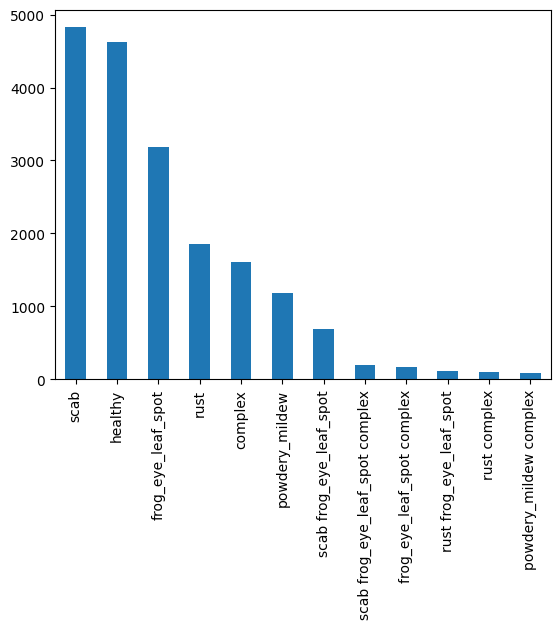

In [7]:
# Replace this file path to shared folder with input images.
shared_folder_fp = "C:/Users/ravis/Desktop/workspace/deep_sentinel"
image_dir_name = "train_images"

image_dir_path = os.path.join(shared_folder_fp, image_dir_name)
train_csv_fp = os.path.join(shared_folder_fp, 'train.csv')
sample_submission_csv_fp = os.path.join(shared_folder_fp, 'sample_submission.csv')

# prepare dataset
train_df = pd.read_csv(train_csv_fp)
train_df['image_local_path'] = train_df['image'].apply(lambda x: os.path.join(image_dir_path, x))

# Preview the training data and label distribution
x=train_df['labels'].value_counts().plot(kind='bar')
print(train_df.iloc[0]['image_local_path'])
train_df.head()



In [8]:
class_counter=collections.Counter(train_df['labels'])
# Preview the sample submission
sample_submission_df = pd.read_csv(sample_submission_csv_fp)
sample_submission_df.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [9]:
classes=list(set(train_df['labels']))
print(classes)
num_classes=len(classes)
ohe_data=pd.get_dummies(train_df['labels'])
train_df_combined = train_df.join(ohe_data)


['healthy', 'rust frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'rust complex', 'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex', 'powdery_mildew', 'complex', 'scab', 'rust', 'scab frog_eye_leaf_spot complex', 'powdery_mildew complex']


In [10]:
# Sampling dataset due to compute constraints
if config.get("subsample"):
    train_df_combined=train_df_combined.sample(n=3000, random_state=7)

In [11]:
# View input training data combined
train_df_combined

,image,labels,image_local_path,complex,frog_eye_leaf_spot,frog_eye_leaf_spot complex,healthy,powdery_mildew,powdery_mildew complex,rust,rust complex,rust frog_eye_leaf_spot,scab,scab frog_eye_leaf_spot,scab frog_eye_leaf_spot complex
10484,c89f8cc4217ae1b7.jpg,frog_eye_leaf_spot,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,1,0,0,0,0,0,0,0,0,0,0
4466,a4648e1b4eddf194.jpg,scab frog_eye_leaf_spot,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,0,0,0,0,0,0,1,0
7653,b5c82897853acd3e.jpg,scab,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,0,0,0,0,0,1,0,0
18203,fdc2f48b16541c69.jpg,scab,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,0,0,0,0,0,1,0,0
8944,bfb7e420d212c3c6.jpg,scab frog_eye_leaf_spot,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,b1de836d425d34b2.jpg,scab,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,0,0,0,0,0,1,0,0
7549,b57cf3b488c20ccb.jpg,scab,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,0,0,0,0,0,1,0,0
9084,c0702f17c4f8fb45.jpg,powdery_mildew,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,0,1,0,0,0,0,0,0,0
18219,fdd2d30b8f1c2861.jpg,healthy,C:/Users/ravis/Desktop/workspace/deep_sentinel...,0,0,0,1,0,0,0,0,0,0,0,0


### Dataset management

In [12]:
train_size = int(0.85 * len(train_df_combined))
test_size = int(0.15 * len(train_df_combined))
val_size = int(0.15 * train_size)
train_size = train_size-val_size

dataset_sizes = {
    'train': train_size,
    'val': val_size,
    'test': test_size
}
print(dataset_sizes)
X_train, X_test, y_train, y_test = train_test_split(
    train_df_combined, train_df_combined['labels'], test_size=test_size, stratify=train_df_combined['labels'])
X_train, X_val, y_train, y_val = train_test_split(
    X_train, X_train['labels'], test_size=val_size, stratify=X_train['labels'])


{'train': 2168, 'val': 382, 'test': 450}


#### Below charts show distribution on train, test and validation data

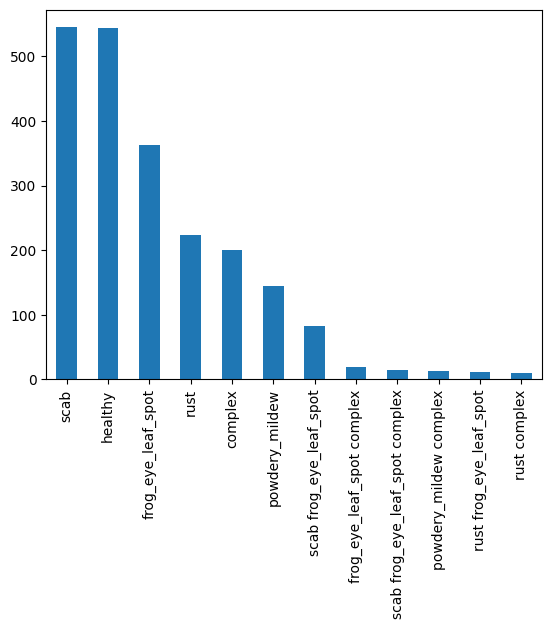

In [13]:
x=X_train['labels'].value_counts().plot(kind='bar')

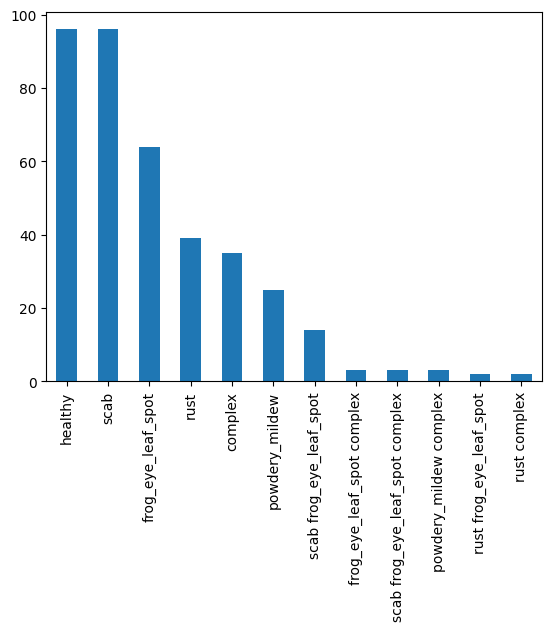

In [14]:

x=X_val['labels'].value_counts().plot(kind='bar')

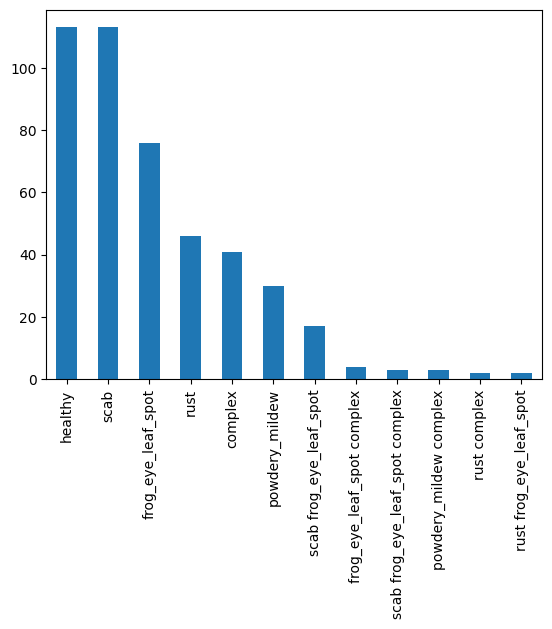

In [15]:

x=X_test['labels'].value_counts().plot(kind='bar')

### Create Model and parameters

In [16]:
# Create pretrained model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc=nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# callbacks and optimizers
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

C:\Users\ravis\Desktop\workspace\deep_sentinel\venv_39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ravis\Desktop\workspace\deep_sentinel\venv_39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Create custom dataloader, Load data with necessary transforms for train, test and val

In [17]:

class LeafDataloader(Dataset):
    def __init__(self, df, split, transform=None):
        """
        df: training or validation dataset
        split: train, val, test
        transform 
        """
        self.df = df
        self.transform = transform
        self.drop_last=True
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_id = self.df.iloc[index]['image']
        image_path=self.df.iloc[index]['image_local_path']
        image = Image.open(image_path).convert('RGB')
        label = self.df.iloc[index]['labels']
        image = self.transform(image)
        label = self.df.iloc[index][-num_classes:]
        label = np.argmax(label)
        label = torch.tensor(label)
        return(image, label, image_id)

print("Custom Data loader created")

Custom Data loader created


In [18]:
train_transform = transforms.Compose([
                                transforms.Resize((image_size, image_size)),
                                transforms.CenterCrop(image_size),
                                transforms.RandomAffine(degrees=20),
                                transforms.RandomRotation(degrees=20),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ])
test_transform = transforms.Compose([
                                transforms.Resize((image_size, image_size)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ])

In [19]:
train_data = LeafDataloader(X_train , split="train" , transform=train_transform)
val_data = LeafDataloader(X_val , split="val" , transform=test_transform)
test_data = LeafDataloader(X_test , split="val" , transform=test_transform)

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False)


In [20]:
plt.close()

### Model training

In [21]:
def train_model(model,train_dataloader, val_dataloader, device, optimizer, scheduler, num_epochs=5):
    """
    Method to train and validate the model on train and validation dataset
    """
    since = time.time()
    dataloaders={
        'train': train_dataloader,
        'val': val_dataloader
    }
    criterion = nn.CrossEntropyLoss()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    """
    # Commenting code related to history since there is a bug
    history = {
        'train_accuracy': [],
        'train_loss': [],
        'val_accuracy':[],
        'val_loss': [],
    }"""
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, image_id in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                #history['train_loss'].append(epoch_loss)
                #history['train_accuracy'].append(epoch_acc)
                scheduler.step()
            #else:
            #    
            #    history['val_loss'].append(epoch_loss)
            #    history['val_accuracy'].append(epoch_acc)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    """
    # Commenting code for history of loss and accuracy since there is a bug
    # Get training and test loss histories
    training_loss = history['train_loss']
    test_loss = history.history['val_loss']
    train_accuracy = history['train_accuracy']
    val_accuracy = history['val_accuracy']

    # Visualize loss history
    plt.plot(range(len(list(training_loss))), training_loss, 'r--')
    plt.plot(range(len(val_loss)), val_loss, 'b-')
    plt.legend(['Training Loss', 'Val Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.savefig('loss.jpg')
    plt.close()
    
    # Visualize accuracy history
    plt.plot(range(len(list(training_accuracy))), training_accuracy, 'r--')
    plt.plot(range(len(val_accuracy)), val_accuracy, 'b-')
    plt.legend(['Training accuracy', 'Val accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show();
    plt.savefig('accuracy.jpg')
    plt.close()
    """
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [22]:


def test(model, device, test_loader):
    """
    Method evaluates the model on test set
    """
    y_target=[]
    y_pred=[]
    image_list=[]
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target, image_id in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_target.extend(target.numpy())
            y_pred.extend(pred.flatten().numpy())
            image_list.extend(image_id)
    test_loss /= len(test_loader.dataset)
    
    
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return y_target, y_pred, image_list

### Train, test and save best model

In [24]:

model= train_model(model, train_dataloader, val_dataloader, device=device, optimizer=optimizer, scheduler=scheduler, num_epochs=epochs)
y_target, y_pred, image_list = test(model, device, test_dataloader)
torch.save(model.state_dict(), "leaf_model.pth")

Epoch 0/5
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████| 136/136 [07:28<00:00,  3.30s/it]


train Loss: 1.8040 Acc: 0.3824


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:57<00:00,  2.38s/it]


val Loss: 1.3794 Acc: 0.4921
Epoch 1/5
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████| 136/136 [07:15<00:00,  3.20s/it]


train Loss: 1.2382 Acc: 0.5544


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:50<00:00,  2.11s/it]


val Loss: 1.1689 Acc: 0.5445
Epoch 2/5
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████| 136/136 [07:58<00:00,  3.52s/it]


train Loss: 1.1338 Acc: 0.5803


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:53<00:00,  2.23s/it]


val Loss: 1.1256 Acc: 0.6021
Epoch 3/5
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████| 136/136 [08:39<00:00,  3.82s/it]


train Loss: 1.1197 Acc: 0.5890


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:00<00:00,  2.52s/it]


val Loss: 1.1100 Acc: 0.6073
Epoch 4/5
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████| 136/136 [08:57<00:00,  3.95s/it]


train Loss: 1.1032 Acc: 0.6024


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:10<00:00,  5.42s/it]


val Loss: 1.1047 Acc: 0.6073
Epoch 5/5
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████| 136/136 [21:12<00:00,  9.36s/it]


train Loss: 1.1084 Acc: 0.5950


100%|████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:14<00:00,  5.59s/it]


val Loss: 1.1234 Acc: 0.6178
Training complete in 69m 38s
Best val Acc: 0.617801


100%|████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [02:48<00:00,  5.79s/it]



Test set: Average loss: -3.4645, Accuracy: 286/450 (63.56%)



In [25]:
y_target, y_pred, image_list = test(model, device, test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [02:42<00:00,  5.59s/it]


Test set: Average loss: -3.4645, Accuracy: 286/450 (63.56%)



### Evaluate model and produce metrics

f1 score:  0.3285644454496968


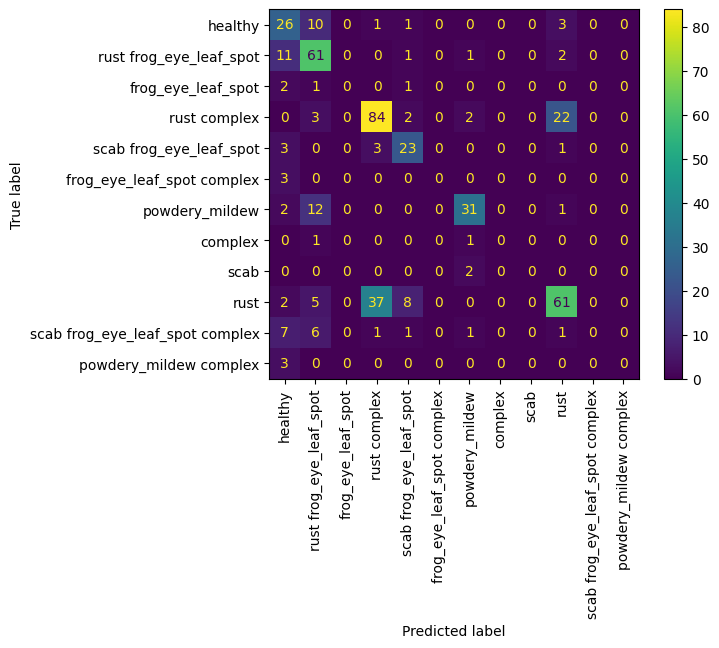

In [26]:
# Evaluation Metrics
f1 = f1_score(y_target, y_pred, average='macro',)
print("f1 score: ",f1)
try:
    # Creating exception when any sample is absent in predictions for a class
    mx = confusion_matrix(y_target, y_pred)
    ConfusionMatrixDisplay(mx, display_labels=classes).plot(xticks_rotation='vertical')
except:
    pass

### Generate report

In [27]:

out_labels = [classes[i] for i in y_pred]
out_report=pd.DataFrame(list(zip(image_list, out_labels)), columns =['image','labels'])
#X_test.join(out_classes)
print(out_report)
out_report.to_csv("report.csv", index=False)

                    image                   labels
0    fb3ff1824d4d4421.jpg  scab frog_eye_leaf_spot
1    bf93801bb0aad24f.jpg                     rust
2    8bca528e4ec64eba.jpg  rust frog_eye_leaf_spot
3    ddb839dd4d25108b.jpg  rust frog_eye_leaf_spot
4    8f97989814fc62c7.jpg             rust complex
..                    ...                      ...
445  f4409e9429f5d363.jpg  rust frog_eye_leaf_spot
446  cad5578b97415692.jpg  rust frog_eye_leaf_spot
447  dd49395b9489663c.jpg           powdery_mildew
448  bb2fe522ff810381.jpg  rust frog_eye_leaf_spot
449  c68f549a0abc7db0.jpg                     rust

[450 rows x 2 columns]
